In [2]:
import numpy as np
import os
import torch
from  models.sae import BatchTopKSAE, JumpReLUSAE, VanillaSAE
from tqdm import tqdm
import matplotlib.pyplot as plt
from evaluate_feature import calculate_AUC_matrix

In [20]:
# Define configurations
cfg = {
    "seed": 49,
    "batch_size": 2048,
    "lr": 3e-3,
    "l1_coeff": 0,
    "dtype": torch.float32,
    "act_size": 768,
    "dict_size": 768*8,
    "device": "cpu",
    "num_batches_in_buffer": 10,
    "dataset_path": "../data/layer_11_embeddings_30subset.npy",
    "input_unit_norm": True,
    "perf_log_freq": 1000,
    "checkpoint_freq": 10000,
    "n_batches_to_dead": 5,
    "max_grad_norm": 100000,
    "n_epochs":5,

    # (Batch)TopKSAE specific
    "top_k": 32,
    "top_k_aux": 512,
    "aux_penalty": (1/64),
}

In [4]:
# Load data
embeddings = np.load(cfg['dataset_path'])
embeddings_flattened = embeddings.reshape(-1,768)

In [5]:
embeddings_flattened.shape

(1977916, 768)

In [6]:
# check sparsity
print(f"Input data l1 norm: {np.mean(np.linalg.norm(embeddings_flattened, ord=1, axis=1)):.4f}")

Input data l1 norm: 173.5387


In [22]:
# Initialize the model
model = BatchTopKSAE(cfg=cfg)

In [23]:
# Training loop
num_batches = embeddings_flattened.shape[0] // cfg['batch_size']
progress_epoch = tqdm(cfg['n_epochs'], desc="Epoch Progress", unit="epoch")
torch.manual_seed(cfg['seed'])
optimizer = torch.optim.Adam(model.parameters(), lr=cfg['lr'])
best_model = None
best_loss = float('inf')
progress_epoch = tqdm(range(cfg['n_epochs']), desc="Epoch Progress", unit="epoch", leave=True, position=1)
for epoch in progress_epoch:
    model.train()
    np.random.shuffle(embeddings_flattened)
    embeddings_flattened = embeddings_flattened[np.random.permutation(embeddings_flattened.shape[0])]
    num_batches = embeddings_flattened.shape[0] // cfg['batch_size']
    progress_batch = tqdm(range(num_batches), desc="Training Progress", unit="batch", leave=True, position=0)
    for batch_idx in progress_batch:
        batch_data = embeddings_flattened[batch_idx*cfg['batch_size']:(batch_idx+1)*cfg['batch_size']]
        if len(batch_data) < cfg['batch_size']:
            continue

        batch_data = torch.tensor(batch_data, dtype=cfg['dtype'], device=cfg['device'])

        sae_output = model(batch_data)
        loss = sae_output['loss']

     
        optimizer.zero_grad()

        progress_batch.set_postfix({"Loss": f"{loss.item():.4f}", "L0": f"{sae_output['l0_norm']:.4f}", "L2": f"{sae_output['l2_loss']:.4f}", "L1": f"{sae_output['l1_loss']:.4f}", "L1_norm": f"{sae_output['l1_norm']:.4f}"})
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), cfg["max_grad_norm"])
        model.make_decoder_weights_and_grad_unit_norm()
        optimizer.step()

        if loss.item() < best_loss:
            best_loss = loss.item()
            best_model = model.state_dict()



Epoch Progress: 0epoch [00:00, ?epoch/s]
Epoch Progress:  20%|██        | 1/5 [13:04<52:17, 784.38s/epoch]


KeyboardInterrupt: 

In [11]:
batch_size = cfg['batch_size']
top_k = cfg['top_k']
embedding_dim = embeddings_flattened.shape[-1]
num_samples = embeddings_flattened.shape[0]
all_topk_indices = []
all_topk_values = []

with torch.no_grad():
    for start in tqdm(range(0, num_samples, batch_size)):
        end = min(start + batch_size, num_samples)
        batch = embeddings_flattened[start:end]
        batch_tensor = torch.tensor(batch, dtype=cfg['dtype'], device=cfg['device'])
        sae_output = model(batch_tensor)
        feature_acts = sae_output["feature_acts"]
        topk_values, topk_indices = torch.topk(feature_acts, top_k, dim=-1)
        all_topk_indices.append(topk_indices.cpu().numpy())
        all_topk_values.append(topk_values.cpu().numpy())

# Concatenate results for all batches
all_topk_indices = np.concatenate(all_topk_indices, axis=0)
all_topk_values = np.concatenate(all_topk_values, axis=0)

100%|██████████| 483/483 [01:07<00:00,  7.21it/s]


In [12]:
# save the results
np.save("../data/topk_indices.npy", all_topk_indices)
np.save("../data/topk_values.npy", all_topk_values)

In [3]:
ground_truth = np.load("../data/chip_exo_57_TF_binding_sites_30subset.npy")
ground_truth_flattened = ground_truth.reshape(-1, 58)[:,57].reshape(-1,1)

In [5]:
ground_truth.reshape(-1, 58).shape

(1977916, 58)

In [15]:
auc_matrix = calculate_AUC_matrix(all_topk_values, ground_truth_flattened)

Output()

In [18]:
all_topk_values.shape

(1977916, 32)

In [16]:
auc_matrix.shape

(32, 1)

In [17]:
auc_matrix

array([[0.49970105],
       [0.49928926],
       [0.50055645],
       [0.50191032],
       [0.50160694],
       [0.50086598],
       [0.50058897],
       [0.50083385],
       [0.50069274],
       [0.50118461],
       [0.50112238],
       [0.50194112],
       [0.50110888],
       [0.50076921],
       [0.49969927],
       [0.49928858],
       [0.49931681],
       [0.49939897],
       [0.49965005],
       [0.4992015 ],
       [0.49919926],
       [0.49904802],
       [0.4993925 ],
       [0.49877903],
       [0.49900689],
       [0.49921152],
       [0.49944577],
       [0.49910303],
       [0.49895628],
       [0.49844628],
       [0.49906768],
       [0.49851648]])

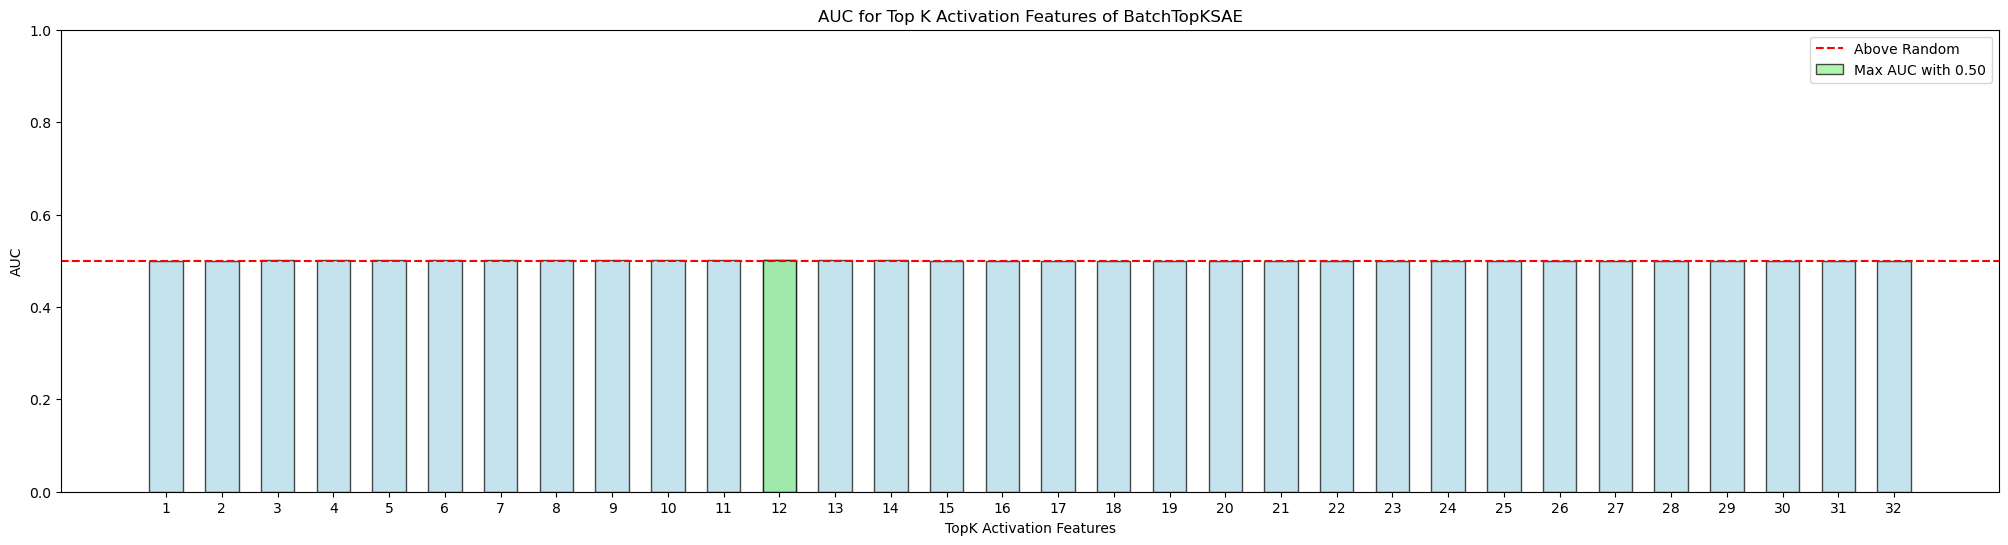

In [19]:
# Plot Bar for AUC of each PC
plt.figure(figsize=(25, 6))
plt.style.use('seaborn-v0_8-deep')
plt.bar(range(1, auc_matrix.shape[0] + 1), auc_matrix.flatten(), color='lightblue', edgecolor='black', width=0.6, alpha=0.7)
plt.axhline(y=0.5, color='red', linestyle='--', label='Above Random')
plt.xlabel('TopK Activation Features')
plt.ylabel('AUC')
plt.title('AUC for Top K Activation Features of BatchTopKSAE')

plt.ylim(0, 1)
plt.xticks(range(1, 33))
# color the bar with higer AUC in green
max_auc = np.max(auc_matrix)
max_auc_index = np.argmax(auc_matrix)
plt.bar(max_auc_index + 1, auc_matrix.flatten()[max_auc_index], color='lightgreen', edgecolor='black', width=0.6, alpha=0.7, label=f'Max AUC with {max_auc:.2f}')
plt.legend()